<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-общей-информации-о-данных" data-toc-modified-id="Изучение-общей-информации-о-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение общей информации о данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-к-обучению" data-toc-modified-id="Подготовка-к-обучению-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Подготовка к обучению</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#Результат-на-тестовой-выборке" data-toc-modified-id="Результат-на-тестовой-выборке-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Результат на тестовой выборке</a></span></li></ul></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

Перед нами исторические данные о заказах такси в аэропортах. Задача: построить модель предсказания количества заказов такси на следующий час. Это нужно, чтобы привлекать больше водителей в период пиковой нагрузки.

**Обзор данных:** Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

## Изучение общей информации о данных


Импортируем библиотеки

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# ignore warnings
warnings.simplefilter('ignore')

# RandomState
state = np.random.RandomState(12345)

Загружаем данные

In [2]:
data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим, в хронологическом ли порядке расположены даты и время

In [3]:
print(data.index.is_monotonic)

True


Выведем основную информацию о данных

In [4]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


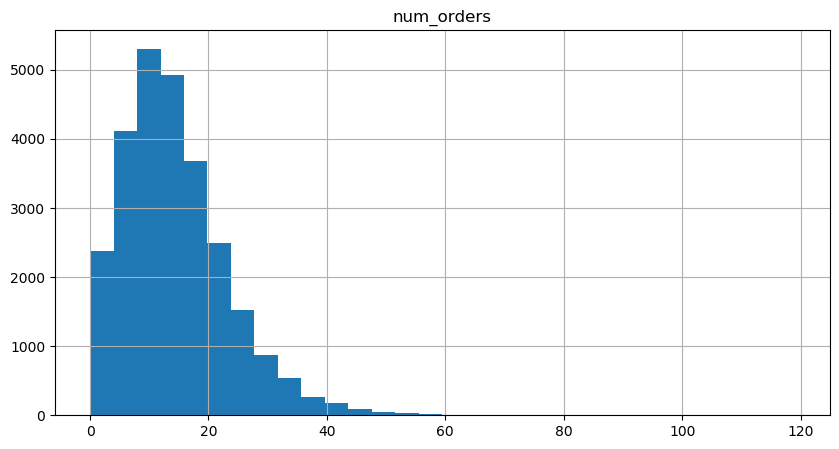

In [7]:
data.hist(bins=30, figsize=(10, 5));

**Вывод:** Данные расположены в хронологическом порядке, пропусков в данных нет, присутствуют аномалии

## Предобработка данных

Выведем диаграмму рассеяния

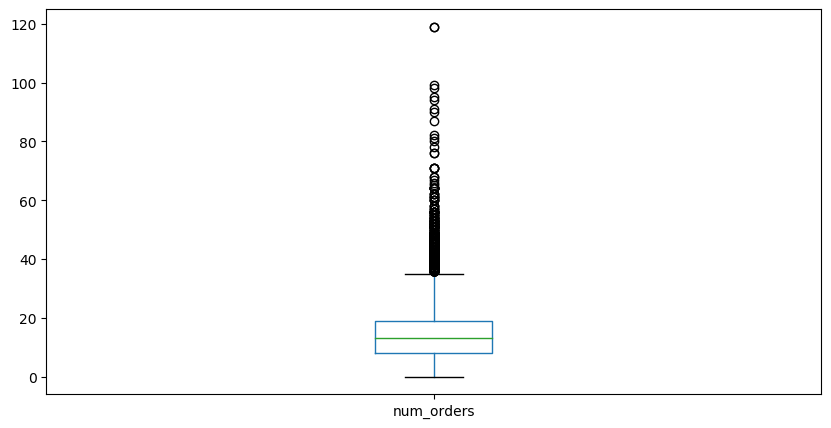

In [8]:
data.plot(kind='box', figsize=(10, 5))

В данных присутствует достаточно много выбросов. Удалим их

In [9]:
z = np.abs(stats.zscore(data))
data = data[(z<3).all(axis=1)]

Ресемплируем данные по временному промежутку в 1 час

In [10]:
data = data.resample('1H').sum()

**Вывод:** Из данных были удалены выбросы (методом z-оценки), данные были ресемплированы по временному промежутку в 1 час

## Исследовательский анализ данных

Выведем графики сезонности, тренда и остатков

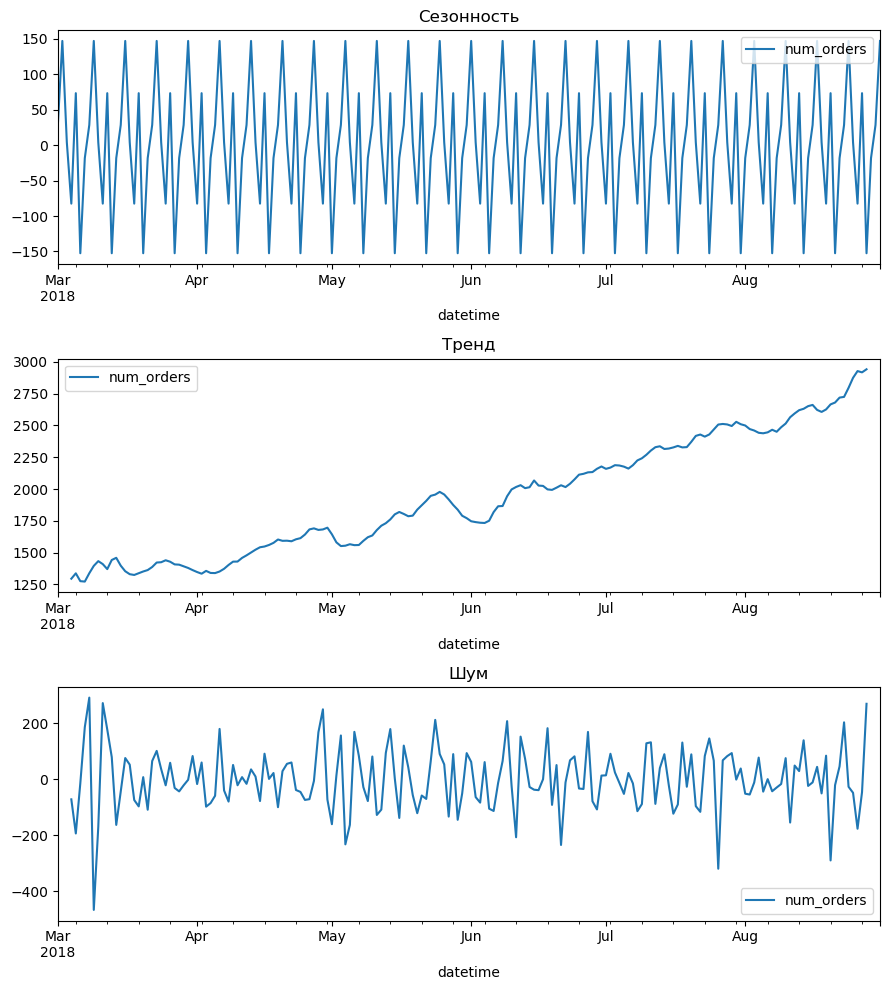

In [11]:
decomposed = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(9, 10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.tight_layout()

График сезонности показывает повторяющийся паттерн, рассмотрим его более детально

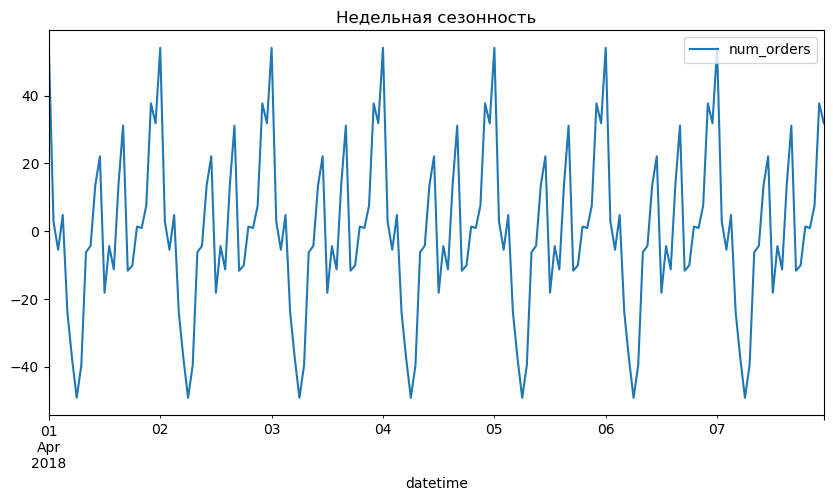

In [12]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-04-07'])
plt.figure(figsize=(10, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Недельная сезонность');

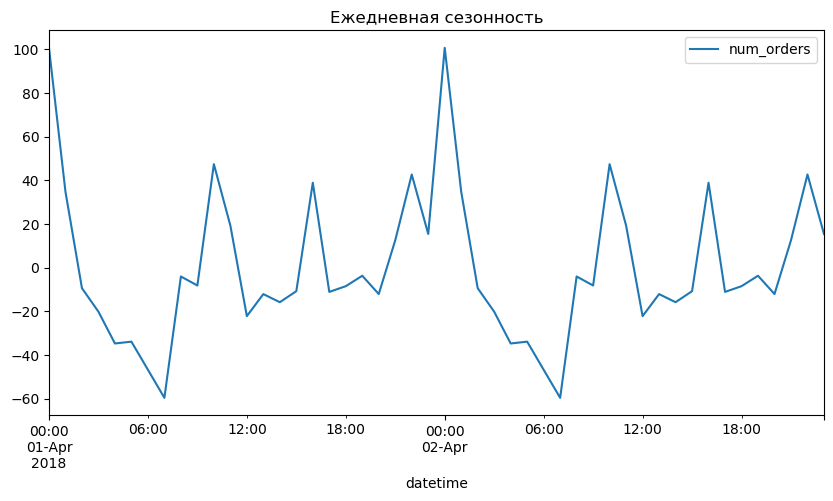

In [13]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-04-02'])
plt.figure(figsize=(10, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Ежедневная сезонность');

Выведем график с плавающими средним и стандартным отклонением (данные ресемплированы по интервалам в 1 день, сглаживание по 10 дням)

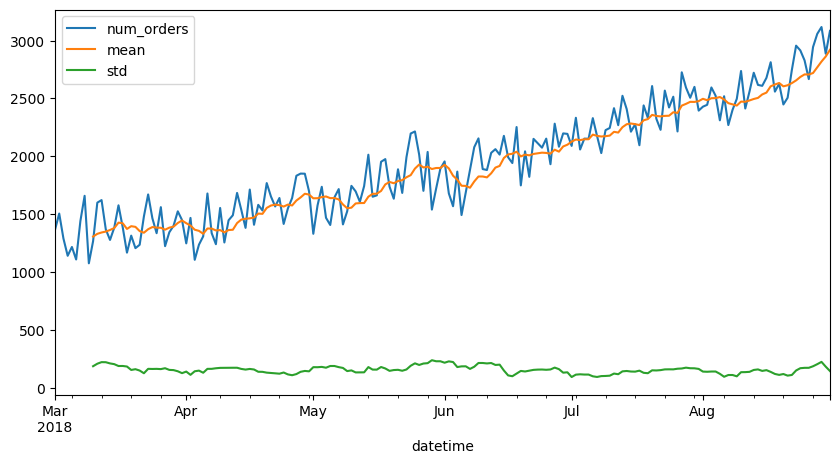

In [14]:
temp = data.resample('1D').sum()
temp['mean'] = temp['num_orders'].rolling(10).mean()
temp['std'] = temp['num_orders'].rolling(10).std()
temp.plot(figsize=(10,5))
del temp

**Вывод:** Пик спроса на такси наблюдается в 00:00 каждого дня. Спрос имеет восходящий тренд, с каждым месяцем количество заказов растёт, а значит растёт и среднее, при этом стандартное отклонение практически не меняется.

## Обучение моделей

### Подготовка к обучению

Напишем функцию, которая обогатит наши данные новыми признаками и разобьёт их на выборки

In [15]:
def make_subsets(data, max_lag, rolling_mean_size):
    
    df = data.copy()

    df['y'] = df['num_orders'].shift(-1)
    df['hour'] = df.index.hour.astype('category')
    df['dayofweek'] = df.index.dayofweek.astype('category')
    for x in range(1, max_lag + 1):
        df[f'shift_{x}'] = df['num_orders'].shift(x)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df.dropna(inplace=True)
    
    X = df.drop('y', axis=1)
    y = df['y']
    X_train, X_temp, y_train, y_temp = \
    train_test_split(X, y,
                     test_size=0.2,
                     shuffle=False)
    X_valid, X_test, y_valid, y_test = \
    train_test_split(X_temp, y_temp,
                     test_size=0.5,
                     shuffle=False)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

### Обучение моделей

#### LinearRegression

Обучим линейную регрессию и выведем значение RMSE для валидационной выборки, подобрав таким образом оптимальные значения `max_lag` и `rolling_mean_size`

In [16]:
best_score = 100

for i in range(1,20):
    for j in range(1,20):
        
        X_train, X_valid, X_test, y_train, y_valid, y_test = make_subsets(data, i, j)
        
        model = LinearRegression().fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        score = mean_squared_error(y_valid, y_pred) ** 0.5
        if score < best_score:
            best_score = score
            besti = i
            bestj = j

X_train, X_valid, X_test, y_train, y_valid, y_test = make_subsets(data, besti, bestj)
print(f'RMSE = {best_score} при max_lag = {besti} и rolling_mean_size = {bestj}')

RMSE = 31.38048048669911 при max_lag = 18 и rolling_mean_size = 9


#### DecisionTreeRegressor

Подберём гиперпараметры для решающего дерева

In [17]:
parametrs = {'max_depth':range(1,10),
             'min_samples_leaf':range(1,13),
             'min_samples_split':range(2,13),
             'random_state':[state]}

clf = DecisionTreeRegressor()

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(clf, parametrs, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
grid.fit(X_train, y_train)

grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'random_state': RandomState(MT19937) at 0x206A00358C8}

Обучим решающее дерево, используя подобранные гиперпараметры и выведем значение RMSE для валидационной выборки

In [18]:
model = DecisionTreeRegressor(max_depth=7, 
                              min_samples_leaf=9, 
                              min_samples_split=2, 
                              random_state=state).fit(X_train, y_train)

y_pred = model.predict(X_valid)
print(mean_squared_error(y_valid, y_pred) ** 0.5)

30.743901088587283


#### GradientBoostingRegressor

Подберём гиперпараметры для GradientBoostingRegressor

In [19]:
parametrs = {'learning_rate':np.arange(0.1,0.4,0.1),
             'max_depth':range(1,6),
             'min_samples_leaf':range(1,11),
             'min_samples_split':range(2,11,2),
             'random_state':[state]}

clf = GradientBoostingRegressor()

grid = GridSearchCV(clf, parametrs, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv)
grid.fit(X_train, y_train)

grid.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_leaf': 10,
 'min_samples_split': 4,
 'random_state': RandomState(MT19937) at 0x206A00358C8}

Обучим GradientBoostingRegressor, используя подобранные гиперпараметры и выведем значение RMSE для валидационной выборки

In [20]:
model = GradientBoostingRegressor(learning_rate=0.1, 
                                  max_depth=4, 
                                  min_samples_leaf=10, 
                                  min_samples_split=4, 
                                  random_state=state).fit(X_train, y_train)

y_pred = model.predict(X_valid)
print(mean_squared_error(y_valid, y_pred) ** 0.5)

26.924881508757963


**Вывод:** GradientBoostingRegressor лучше остальных моделей справился с предсказанием

#### Результат на тестовой выборке

Объединим тренировочные выборки с валидационными, обучим на них GradientBoostingRegressor и выведем значение RMSE для тестовой выборки 

In [21]:
X_train = pd.concat([X_train, X_valid])
y_train = pd.concat([y_train, y_valid])

model = GradientBoostingRegressor(learning_rate=0.1, 
                                  max_depth=4, 
                                  min_samples_leaf=10, 
                                  min_samples_split=2, 
                                  random_state=state).fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred) ** 0.5)

34.360644521266416


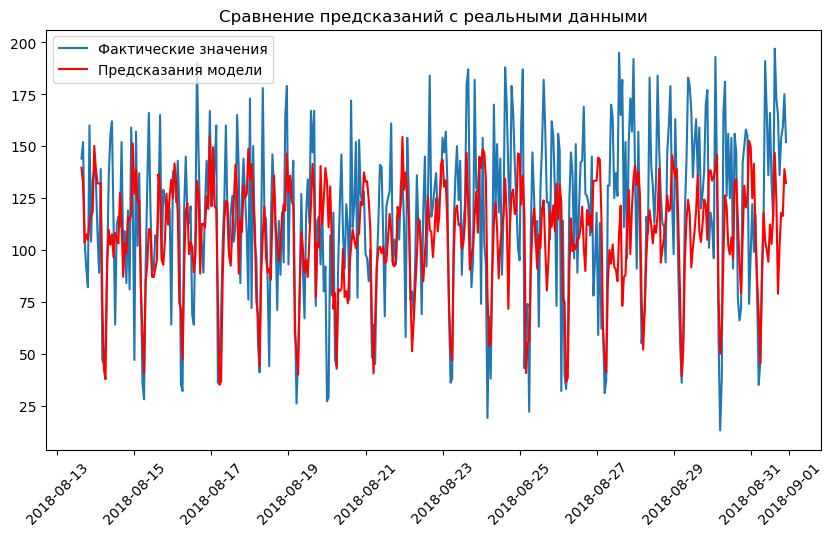

In [22]:
plt.figure(figsize=(10,12))
plt.subplot(211)
plt.title('Сравнение предсказаний с реальными данными')
a = plt.plot(X_test.index, y_test, label='Фактические значения')
b = plt.plot(X_test.index, y_pred, color='red', label='Предсказания модели')
plt.legend()
plt.xticks(rotation=45);

Сравним с RMSE предсказаний константной модели с константой средним по тренировочным данным

In [23]:
y_pred = np.ones(y_test.shape) * y_train.mean()

print(mean_squared_error(y_test, y_pred) ** 0.5)

55.06532107647773


**Вывод:** RMSE на тестовой выборке немного больше, чем на валидационной. Это может быть связано как с тем, что стандартное отклонение у тестовой выборки больше, так и с тем, что в данных присутствует много необъяснимых зависимостей (к примеру, в какой-то день распределение количества заказов изменилось из-за случайного события).

## Общий вывод

Прогнозирование количества заказов машинным обучением по временным рядам уже активно используется ведущими агрегаторами такси и поставщиками транспортных услуг. В целом, такой подход может привести к более точным прогнозам и повышению эффективности транспортных систем. Однако, для достижения оптимальных результатов, необходимо учитывать различные факторы, такие как качество данных, выбор подходящих моделей и правильное обучение моделей.

В ходе работы:
1) Полученые данные были изучены, были выявлены аномальные значения
2) Данные были предобработаны, были удалены аномалии, добавлены `dayofweek`, `rolling_mean` и 3 столбца сдвига с шагом в 1 час
3) Данные были разделены на подвыборки и подготовлены к применению в обучении
4) Были выбраны несколько моделей (LinearRegression, DecisionTreeRegressor, GradientBoostingRegressor). Для них были подобраны гиперпараметры там, где это возможно, проверена метрика RMSE по валидацонной выборке. Модель GradientBoostingRegressor с гиперпараметрами `max_depth=4`, `min_samples_leaf=10` и `min_samples_split` лучше остальных справилась с задачей (RMSE=27).
5) Качество предсказаний GradientBoostingRegressor было повторно проверено метрикой RMSE на тестовой выборке. Оно оказалось слегка хуже, чем на валидационной (RMSE=34)

Для предсказания временных рядов можно использовать и специализированные модели (например, ARIMA из библиотеки statsmodels), но качество предсказаний вряд ли существенно повысится. Для достижения лучших результатов прогнозирования можно попробовать обогатить датасет новыми данными (например, количеством приходящих и уходящих за час рейсов). Увеличение количества признаков может дать существенный прирост точности предсказаний модели.